# Patient Survival Classification Task
### Nafis Ahmed


## Import Libraries

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

## Load Dataset

In [341]:
#Imported the data set and saw that there were no column labels in the data set, so I added
#my own labels.
dtf = pd.read_csv("a1_data.csv", 
                  names=["Age", "Year", "Nodes", "Status"])
dtf.head()

,Age,Year,Nodes,Status
0,30.0,64.0,1.0,1
1,30.0,62.0,3.0,1
2,30.0,65.0,0.0,1
3,31.0,59.0,2.0,1
4,31.0,65.0,4.0,1


## Examine Dataset

In [7]:
dtf["Status"].value_counts()

1    225
2     81
Name: Status, dtype: int64

In [8]:
dtf.describe()

,Age,Year,Nodes,Status
count,304.000000,305.000000,304.000000,306.000000
mean,52.559211,62.842623,4.046053,1.264706
std,10.764343,3.249720,7.208666,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,61.000000,65.000000,4.250000,2.000000
max,83.000000,69.000000,52.000000,2.000000


In [342]:
#Rename column 'Status' to 'Y' for as prediction
dtf = data.rename(columns={"Status":"Y"})
dtf.head()

,Age,Year,Nodes,Y
0,30.0,64.0,1.0,1
1,30.0,62.0,3.0,1
2,30.0,65.0,0.0,1
3,31.0,59.0,2.0,1
4,31.0,65.0,4.0,1


###  Discover and Visualize the Data to gain insights

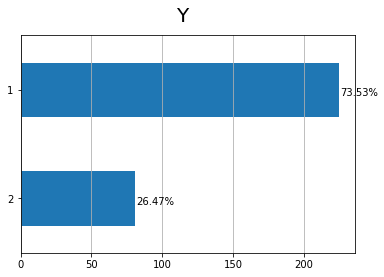

In [11]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

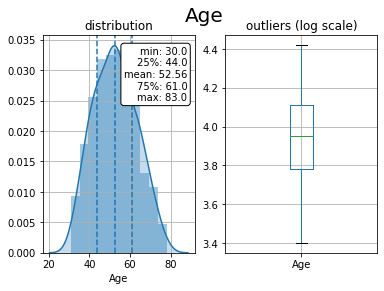

In [19]:
x = "Age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = dtf[x].fillna(dtf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = dtf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(dtf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

In [118]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, 
                      test_size=0.2)

In [35]:
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (244, 3) | X_test shape: (62, 3)
y_train mean: 1.23 | y_test mean: 1.39
4 features: ['Age', 'Year', 'Nodes']


### Prepare the data to better expose the underlying data patterns to machine learning algorithm

In [116]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]

dtf_scaled

,Age,Year,Nodes,Y
18,0.442997,0.868700,0.000000,1
279,0.818369,0.970822,0.000000,1
137,0.612520,0.854111,0.057692,2
39,0.467215,0.912467,0.076923,1
1,0.358236,0.897878,0.057692,1
...,...,...,...,...
84,0.539867,0.970822,0.000000,1
254,0.769934,0.941645,0.423077,1
48,0.491432,0.854111,0.000000,1
8,0.406671,0.000000,0.173077,2


Text(0.5, 1, 'pearson correlation')

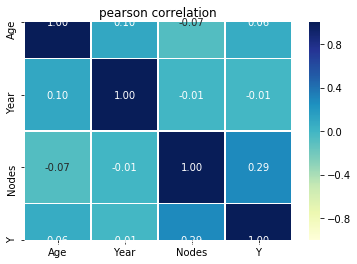

In [43]:
corr_matrix = dtf.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [119]:
dtf_train = dtf_train.fillna(dtf_train.median())
dtf_train

,Age,Year,Nodes,Y
85,45.0,59.0,14.0,1
48,41.0,59.0,0.0,1
273,67.0,64.0,8.0,2
60,42.0,65.0,0.0,1
112,48.0,64.0,0.0,1
...,...,...,...,...
234,61.0,64.0,0.0,1
38,39.0,59.0,2.0,1
250,63.0,66.0,0.0,1
40,40.0,58.0,2.0,1


In [279]:
X = dtf_train.drop("Y", axis=1).values

In [313]:
x1= dtf.drop('Y', axis = 1)
y1= dtf['Y']
X_train, X_test, Y_train, Y_test = train_test_split(x1,y1, test_size = 0.2, random_state = 32)

In [334]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

## Random Forest Classifier Prediction

In [335]:
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_train, Y_train)
pred_rfc = rfc.predict(X_test)

In [336]:
pred_rfc[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
      dtype=int64)

### Evaluate

In [333]:
print(classification_report(Y_test, pred_rfc))
#1 The patient survived 5 years or more has a precision of 0.75
#2 The precision for patients survived for less than 5 years is 0.4 

              precision    recall  f1-score   support

           1       0.75      0.93      0.83        46
           2       0.40      0.12      0.19        16

    accuracy                           0.73        62
   macro avg       0.58      0.53      0.51        62
weighted avg       0.66      0.73      0.67        62



## SVM Classifier

In [345]:
clf = svm.SVC()
clf.fit(X_train, Y_train)
pred_clf = clf.predict(X_test)
pred_clf[:20]

array([1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
      dtype=int64)

### Evaluate

In [340]:
print(classification_report(Y_test, pred_clf))
print(confusion_matrix(Y_test, pred_clf))

              precision    recall  f1-score   support

           1       0.77      0.96      0.85        46
           2       0.60      0.19      0.29        16

    accuracy                           0.76        62
   macro avg       0.69      0.57      0.57        62
weighted avg       0.73      0.76      0.71        62

[[44  2]
 [13  3]]


## Evaluation

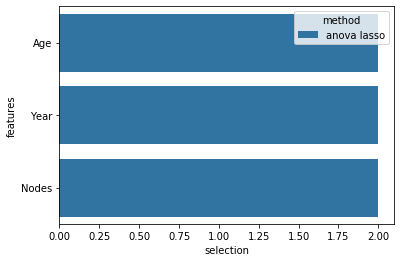

In [134]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=3).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=3).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

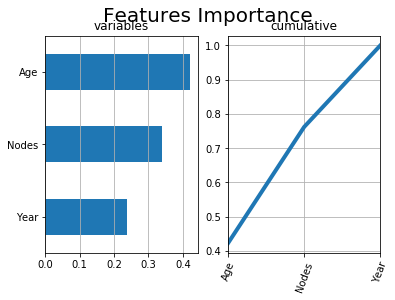

In [139]:
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances,"VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4,legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)),xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [141]:
X_names = ["Age", "Year", "Nodes"]
X_train = dtf_train[X_names].values
y_train = dtf_train["Y"].values
X_test = dtf_test[X_names].values
y_test = dtf_test["Y"].values

In [150]:
## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.

## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=100, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

C:\Users\Nafis\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Nafis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Model parameters: {'subsample': 0.7, 'n_estimators': 1750, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.005}
Best Model mean accuracy: 0.7622950819672131


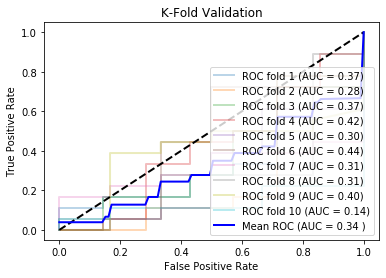

In [246]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
    fpr, tpr, t = metrics.roc_curve(y_train[test], prediction[:, 1],pos_label = 1)
    tprs.append(scipy.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i = i+1
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

In [247]:
## train
model.fit(X_train, y_train)
## test
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

In [248]:
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.76
Auc: 0.66
Recall (all 1s predicted right): 0.96
Precision (confidence when predicting a 1): 0.77
Detail:
              precision    recall  f1-score   support

           1       0.77      0.96      0.85        45
           2       0.67      0.24      0.35        17

    accuracy                           0.76        62
   macro avg       0.72      0.60      0.60        62
weighted avg       0.74      0.76      0.71        62



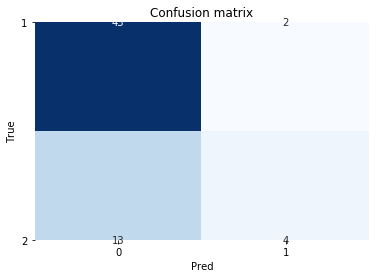

In [249]:
classes = np.unique(y_test)
fig, ax = plt.subplots()
cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
ax.set_yticklabels(labels=classes, rotation=0)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'annotate'

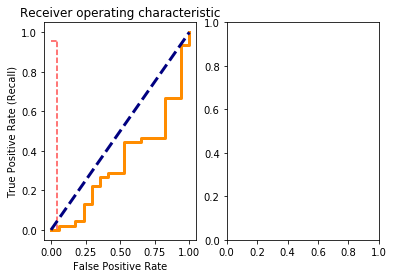

In [261]:
classes = np.unique(y_test)
fig, ax = plt.subplots(nrows=1, ncols=2)
## plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)     

ax[0].plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].hlines(y=recall, xmin=0, xmax=1-cm[0,0]/(cm[0,0]+cm[0,1]), color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[0].vlines(x=1-cm[0,0]/(cm[0,0]+cm[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7)
ax[0].set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     

## annotate ROC thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
     t = np.round(t,1)
     if t not in thres_in_plot:
         ax.annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i],tpr[i]), 
              textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
     else:
         next
## plot P-R curve
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, predicted_prob)
roc_auc = metrics.auc(recalls, precisions)
ax[1].plot(recalls, precisions, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
ax[1].plot([0,1], [(cm[1,0]+cm[1,0])/len(y_test), (cm[1,0]+cm[1,0])/len(y_test)], linestyle='--', color='navy', lw=3)
ax[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label="chosen threshold")
ax[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7)
ax[1].set(xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")

## annotate P-R thresholds
thres_in_plot = []
for i,t in enumerate(thresholds):
    t = np.round(t,1)
    if t not in thres_in_plot:
         ax.annotate(np.round(t,1), xy=(recalls[i],precisions[i]), 
               xytext=(recalls[i],precisions[i]), 
               textcoords='offset points', ha='left', va='bottom')
         thres_in_plot.append(t)
    else:
         next
plt.show()

In [272]:
print("True:", y_test[4], "--> Pred:", predicted[4], "| Prob:", np.max(predicted_prob[4]))

True: 1 --> Pred: False | Prob: 0.04945206675669155


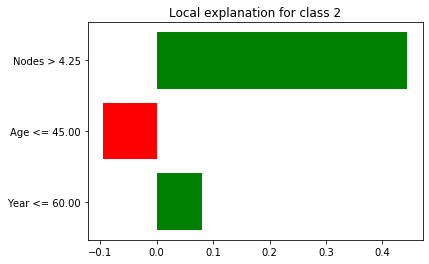

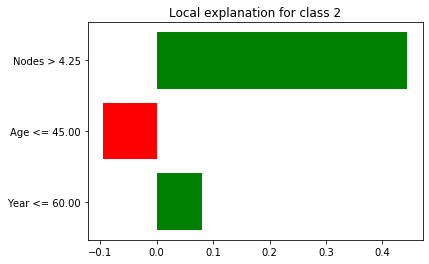

In [276]:
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=X_names, class_names=np.unique(y_train), mode="classification")
explained = explainer.explain_instance(X_test[4], model.predict_proba, num_features=10)
explained.as_pyplot_figure()